In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import pandas as pd
import splat
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import numba
from tqdm import tqdm
%matplotlib inline

In [2]:
#dfcand=pd.read_csv(wisps.LIBRARIES+'/candidates.csv')

In [3]:
SIMULATED_DIST=wispsim.simulate_spts()

In [4]:
import wisps.simulations.effective_numbers as ef 

In [5]:
data=ef.simulation_outputs()

In [6]:
MASSES=SIMULATED_DIST['mass']

In [7]:
NORM = 0.0055/ len(MASSES[np.logical_and(MASSES>=0.09, MASSES <=0.1)])

In [8]:
def custom_histogram(things, grid):
    n=[]
    for g in grid:
        n.append(len(things[np.logical_and(g<=things, things< g+1)]))
    return np.array(n)

In [9]:
nobs0=custom_histogram((SIMULATED_DIST['spts'][0][:,0]), data['spgrid'])

In [10]:
nobs0

array([ 6248,  5119,  4174,  2742,  2527,  2258,  2118,  2176,  1940,
        2008,  1876,  1674,  1450,  1229,  1209,  1561,  2185,  3322,
        5406,  8674, 12882, 18924,     0,     0,     0])

In [11]:
drop_nan=ef.drop_nan

In [12]:
import splat.empirical as spem

In [13]:
SIMULATED_DIST.keys()

dict_keys(['mass', 'ages', 'teffs', 'spts', 'norm', 'betas'])

In [14]:
idx0=np.isnan(SIMULATED_DIST['teffs'])[0]

In [15]:
nan_masses=SIMULATED_DIST['mass'][idx0]
nan_ages=(SIMULATED_DIST['ages'][0])[idx0]

In [16]:
import seaborn as sns

In [17]:
cmap= sns.cubehelix_palette(10, as_cmap=True)

Text(0.5, 1.0, 'Age (Gyr)')

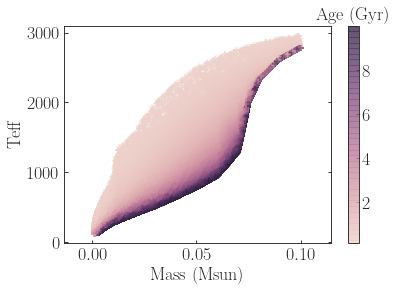

In [18]:
c=plt.scatter(SIMULATED_DIST['mass'],SIMULATED_DIST['teffs'][4], c=SIMULATED_DIST['ages'][4], marker='+', cmap=cmap, alpha=.5)
plt.xlabel('Mass (Msun)', fontsize=18)
plt.ylabel('Teff ', fontsize=18)
c=plt.colorbar()
c.ax.set_title('Age (Gyr)', fontsize=18)

In [19]:
from matplotlib.ticker import MultipleLocator
import seaborn as sns
ml1 = MultipleLocator(1.)
ml2 = MultipleLocator(10.)cand

In [20]:
cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf', key='with_indices')

In [21]:
def get_survey(grism_id):
    if grism_id.lower().startswith('par'):
        return 'wisp'
    else:
        return 'hst3d'

def get_mags(row):
    return pd.Series(row.spectra.mags)

In [22]:
mags_df=cands.apply(get_mags, axis=1)

In [23]:
tab=wisps.Annotator.reformat_table(cands.join(mags_df))

In [24]:
tab['survey']=tab['grism_id'].apply(get_survey)

In [25]:
#tab.columns

In [26]:
#bin in orders of 5 spts

def bin_by_spt_bin(sp_types, number):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def stay_within_limits(row):
    #print (row)
    flag=True
    if row.survey.lower()=='wisp':
        if ((row['F110W']>wisps.MAG_LIMITS['wisps']['F110W'][0]) or (row['F110W']<wisps.MAG_LIMITS['wisps']['F110W'][1])):
            flag=False
        if np.isnan(row['F110W']):
            flag=True
            
    if row.survey.lower()=='hst3d':
        if (row['F140W']>wisps.MAG_LIMITS['hst3d']['F140W'][0]) or (row['F140W']<wisps.MAG_LIMITS['hst3d']['F140W'][1]):
            flag=True
        if np.isnan(row['F140W']):
            flag=True
            
    if splat.typeToNum(row.spt)<17.:
        flag=False
    return flag

In [27]:
flags=tab.apply(stay_within_limits, axis=1).values

In [28]:
cdf_to_use=tab[flags]

In [29]:
wisps.MAG_LIMITS['wisps']['F110W']

[22.0, 18.0]

In [30]:
cdf_to_use.shape, tab.shape

((137, 21), (269, 21))

In [31]:
nobs=custom_histogram(cdf_to_use.spt.apply(wisps.make_spt_number), data['spgrid'])

In [32]:
np.nansum(nobs), cdf_to_use.shape

(137, (137, 21))

In [33]:
spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']

In [34]:
data['hs']

[100, 250, 275, 300, 325, 350, 1000]

In [35]:
from matplotlib.colors import Normalize

In [36]:
cnorm=Normalize(data['hs'][1], data['hs'][-2])

In [37]:
hs=data['hs']

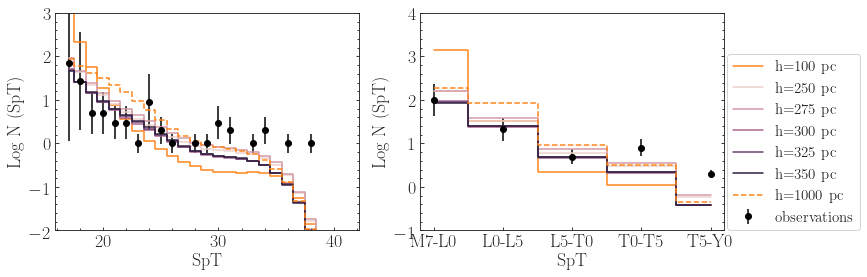

In [38]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(12, 4))

for x, y in zip(data['spgrid'],nobs):
    if y>0:
        dy=np.sqrt(y)
        dyerr=(y/dy)*np.log10(2.7)*0.5
        #ax.errorbar(x,y, yerr=np.sqrt(y), label='observations',fmt='o', color='k')
        ax.errorbar(x, np.log10(y), yerr=dyerr,  label='observations',fmt='o', color='k')
    if y==0:
        pass
        #ax.plot(x, y, linestyle='none', marker=r'$\downarrow$',   label='observations', color='k')
        
for idx in np.arange(len(hs)):
        
        if hs[idx]==100:
            ax.step(data['spgrid'], np.log10(data['n'][idx]*(data['vol'].T)[idx]*NORM),   where='mid', 
                    label='h={} pc'.format(hs[idx]),color='#FF851B')
            ax1.step(spgrid2, np.log10(bin_by_spt_bin(data['spgrid'], (data['n'][idx])*((data['vol'].T)[idx]*NORM))), 
                     where='mid', label='h={} pc'.format(hs[idx]), color='#FF851B')
            
        elif hs[idx]==1000:
            ax.step(data['spgrid'], np.log10(data['n'][idx]*(data['vol'].T)[idx]*NORM),  
                    where='mid', label='h={} pc'.format(hs[idx]), color='#FF851B', linestyle='--')
            ax1.step(spgrid2, np.log10(bin_by_spt_bin(data['spgrid'], (data['n'][idx])*((data['vol'].T)[idx]*NORM))), 
                     where='mid', label='h={} pc'.format(hs[idx]), 
             color='#FF851B', linestyle='--')
            
        else:
            ax.step(data['spgrid'], np.log10(data['n'][idx]*(data['vol'].T)[idx]*NORM),  
                    where='mid', label='h={} pc'.format(hs[idx]), color=cmap(cnorm(hs[idx])) )
            ax1.step(spgrid2, np.log10(bin_by_spt_bin(data['spgrid'], (data['n'][idx])*((data['vol'].T)[idx]*NORM))), 
                     where='mid', label='h={} pc'.format(hs[idx]), color=cmap(cnorm(hs[idx])))
   


#ax1.errorbar(spgrid2,bin_by_spt_bin(data['spgrid'],nobs),yerr=np.sqrt(bin_by_spt_bin(data['spgrid'],nobs)),
#            label='observations',fmt='o', color='k')


y2=np.log10(bin_by_spt_bin(data['spgrid'],nobs))
dy2=np.sqrt(np.sqrt(y2))
y2_err=(y2/dy2)*np.log10(2.7)*0.5

ax1.errorbar(spgrid2,np.log10(bin_by_spt_bin(data['spgrid'],nobs)), yerr=y2_err,
            label='observations',fmt='o', color='k')
             
ax1.legend( fontsize = 15., loc=(1.01, 0.))

ax.minorticks_on()

ax1.minorticks_on()
ax.set_ylim([-2, 3.])
ax1.set_ylim([-1, 4.])

ax1.tick_params(axis='x', which='minor', bottom=False)


ax.set_ylabel('Log N (SpT)', fontsize=18)
ax1.set_ylabel('Log N (SpT)', fontsize=18)
ax.set_xlabel('SpT', fontsize=18)
ax1.set_xlabel('SpT', fontsize=18)

plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf', bbox_inches='tight')



In [39]:
co_sl_prob=np.array(data['sl_prob'])
co_dist=np.array(data['dists'])
co_f140=np.array(data['appf140s'])
co_snrj=np.array(data['snrjs'])

In [40]:
co_sl_prob[0].shape, co_dist.shape

((97705,), (7, 97705))

In [41]:
rdf=pd.DataFrame()
rdf['mags0']=np.concatenate(co_f140)
rdf['mags1']=np.concatenate(data['appf160s'])

In [42]:
flags0=rdf.mags0.between(18, 22.5).values
flags1=rdf.mags1.between(16, 21.5).values

In [43]:
flag=np.logical_or(flags0, flags1)

In [44]:
flag.shape, flags0.shape, flags1.shape, rdf.shape

((683935,), (683935,), (683935,), (683935, 2))

In [45]:
rdf[flag].shape

(608795, 2)

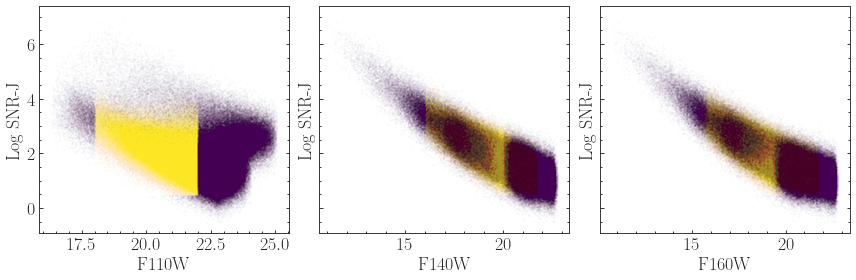

In [46]:
fig, ax=plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

p=ax[0].scatter( np.array(data['appf110s']), np.log10(co_snrj), s=1., marker=',', c=co_sl_prob, cmap='viridis', alpha=0.01)
p=ax[1].scatter( np.array(data['appf140s']), np.log10(co_snrj), s=1., marker=',', c=co_sl_prob, cmap='viridis', alpha=0.01)
p=ax[2].scatter( np.array(data['appf160s']), np.log10(co_snrj), s=1., marker=',', c=co_sl_prob, cmap='viridis', alpha=0.01)

for a in ax:
    a.set_ylabel('Log SNR-J', fontsize=18)
    a.minorticks_on()

ax[0].set_xlabel('F110W', fontsize=18)
ax[1].set_xlabel('F140W', fontsize=18)
ax[2].set_xlabel('F160W', fontsize=18)
plt.tight_layout()

#ax[0].axhline(21.5, c='k', linestyle='--')
#ax[0].axvline(np.log10(3.), c='k', linestyle='--')


In [47]:
data.keys()

dict_keys(['f110', 'f140', 'hs', 'f160', 'appf140s', 'appf110s', 'appf160s', 'dists', 'snrjs', 'n', 'spgrid', 'vol', 'sl_prob'])

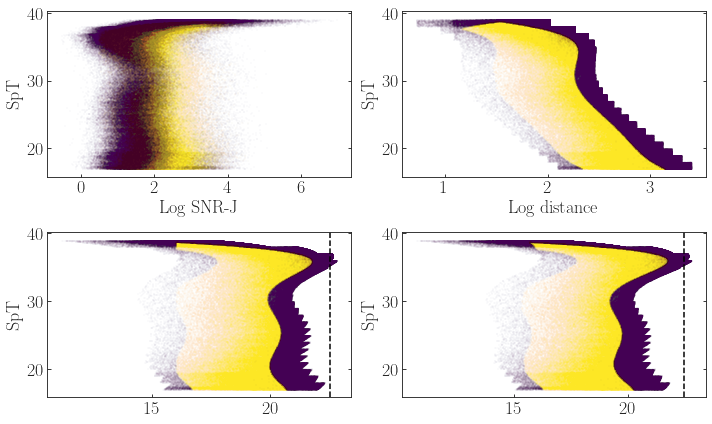

In [48]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(10, 6))

for idx, h in enumerate(hs): 

    p=ax[0][0].scatter(np.log10(co_snrj)[idx],drop_nan(SIMULATED_DIST['spts'][0][:,0]), s=1., 
                    marker=',', c=co_sl_prob[idx], cmap='viridis', alpha=0.01)
    
    p=ax[0][1].scatter(np.log10((data['dists'][idx])),drop_nan(SIMULATED_DIST['spts'][0][:,0]), s=1., 
                    marker=',', c=co_sl_prob[idx], cmap='viridis', alpha=0.01)
    
    p=ax[1][0].scatter((data['appf140s'][idx]),drop_nan(SIMULATED_DIST['spts'][0][:,0]), s=1., 
                    marker=',', c=co_sl_prob[idx],cmap='viridis', alpha=0.01)
    p=ax[1][1].scatter((data['appf160s'][idx]),drop_nan(SIMULATED_DIST['spts'][0][:,0]), s=1., 
                    marker=',', c=co_sl_prob[idx],cmap='viridis', alpha=0.01)
    
ax[1][1].axvline(wisps.MAG_LIMITS['hst3d']['F140W'][0], c='k', linestyle='--')
ax[1][0].axvline(wisps.MAG_LIMITS['hst3d']['F160W'][0], c='k', linestyle='--')

ax[0][0].set_ylabel('SpT', fontsize=18)
ax[0][1].set_ylabel('SpT', fontsize=18)
ax[1][0].set_ylabel('SpT', fontsize=18)
ax[1][1].set_ylabel('SpT', fontsize=18)
            

ax[0][0].set_xlabel('Log SNR-J', fontsize=18)
ax[0][1].set_xlabel('Log distance', fontsize=18)

plt.tight_layout()

In [49]:
#the selection function should be the number of objects that I select over the number of objects i "SHOULD select"
#not the number of objects i simulated 

In [50]:
from tqdm import tqdm

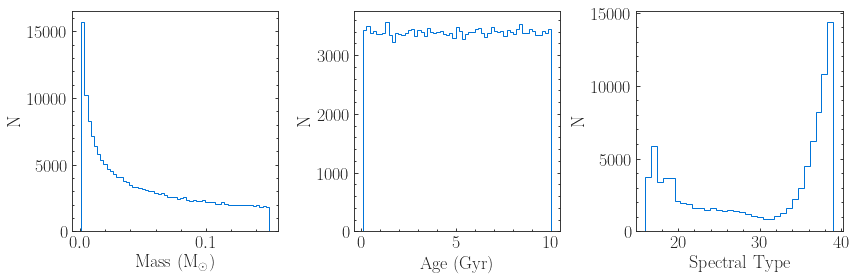

In [51]:
fig, ax=plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

h= ax[0].hist(SIMULATED_DIST['mass'],  histtype='step', bins='auto', color='#0074D9')


    
#ax[1][0].set_yscale('log')
#ax[1][1].set_yscale('log')
#ax[1][2].set_yscale('log')

#ax[1][2].axvline(21.5)

    
h=ax[2].hist(SIMULATED_DIST['spts'][0][:,0],  histtype='step', bins='auto', color='#0074D9')
h=ax[1].hist(SIMULATED_DIST['ages'][0],  histtype='step', bins='auto', color='#0074D9')

ax[0].set_xlabel(r'Mass (M$_\odot$)', fontsize=18)
ax[2].set_xlabel('Spectral Type', fontsize=18)
ax[1].set_xlabel('Age (Gyr)', fontsize=18)

#ax[1][0].set_xlabel('Log Distance (pc)', fontsize=18)
#ax[1][1].set_xlabel('Log SNR-J', fontsize=18)
#ax[1][2].set_xlabel('F140W', fontsize=18)

for a in ax:
    a.minorticks_on()
    a.set_ylabel('N', fontsize=18)
    
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/simulations_dists.pdf', bbox_inches='tight')

In [52]:
import wisps.simulations.effective_numbers as eff

In [53]:
data.keys()

dict_keys(['f110', 'f140', 'hs', 'f160', 'appf140s', 'appf110s', 'appf160s', 'dists', 'snrjs', 'n', 'spgrid', 'vol', 'sl_prob'])

In [54]:
import matplotlib as mpl

In [55]:
cnorm=Normalize(data['hs'][0], data['hs'][-1])

100%|██████████| 7/7 [00:00<00:00, 21.84it/s]


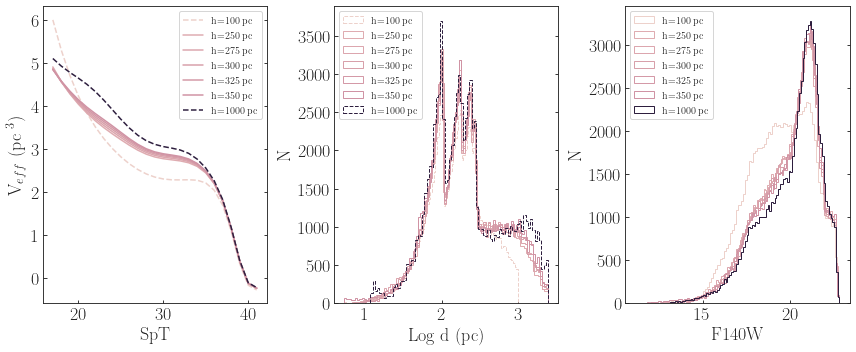

In [56]:
fig, ax=plt.subplots(ncols=3, nrows=1, figsize=(12, 5))


for  idx in tqdm(np.arange(len(hs))):

    #col=cmap(cnorm(hs[idx]))

    linestyle='-'
    if hs[idx]==100:
        linestyle='--'

    if hs[idx]==1000:
        #col='#FF851B'
        linestyle='--'

    h=ax[0].plot(data['spgrid'], np.log10((data['vol'].T)[idx]), label='h={} pc'.format(hs[idx]), 
              linestyle= linestyle, color=cmap(cnorm(hs[idx])))

    h=ax[1].hist(np.log10((np.array(data['dists'])[idx])),  bins='auto', histtype='step',
                   label='h={} pc'.format(hs[idx]), 
              linestyle= linestyle, color=cmap(cnorm(hs[idx])))

    h=ax[2].hist(drop_nan((np.array(data['appf140s'])[idx])), bins='auto', histtype='step', label='h={} pc'.format(hs[idx]),
                 color=cmap(cnorm(hs[idx])))


ax[0].set_xlabel('SpT', fontsize=18)
ax[0].set_ylabel(r'V$_{eff}$ (pc $^3$)', fontsize=18)


ax[1].set_xlabel(r'Log d (pc)', fontsize=18)
ax[1].set_ylabel('N', fontsize=18)

ax[2].set_xlabel(r'F140W', fontsize=18)
ax[2].set_ylabel('N', fontsize=18)


ax[0].legend(prop={'size': 10},loc='upper right')
ax[1].legend(prop={'size': 10},loc='upper left')
ax[2].legend(prop={'size': 10},loc='upper left')

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/simulations_dists_selection_effects.pdf', bbox_inches='tight')

In [57]:
import splat.empirical as spe

In [58]:
def ryan_lf(spt):
    #ryan's luminosity function 
    J=spe.typeToMag(spt, '2MASS J')[0]
    logphi=-0.30 + 0.11*(J-14) + 0.15*(J -14)**2.+ 0.015*(J-14)**3-0.00020*(J-14)**4
    return (10**logphi)*(10**-3)

In [59]:
spgrid=data['spgrid']

In [60]:
(data['vol']).shape

(25, 7)

In [61]:
ryan_n=np.array([ryan_lf(spgrid[idx])*(data['vol'].T)[0][idx] for idx in range(len(spgrid)) ])

In [62]:
ryan_n.shape

(25,)

In [63]:
hist=custom_histogram(drop_nan(SIMULATED_DIST['spts'][idx][:,0]), data['spgrid'])

In [64]:
VOLUMES=(data['vol'].T)

In [65]:
(data['n']).shape, (data['vol']).shape, wisps.MAG_LIMITS['hst3d']['F140W']

((23,), (25, 7), [22.5, 16.0])

In [66]:
(data['spgrid']).shape, (np.log10(data['n'][idx]*(data['vol'].T)[idx]*NORM)).shape

((25,), (25,))

In [67]:
snew=np.arange(17, 39)

In [68]:
snew

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [69]:
sptidx=[i for i, spt in enumerate(data['spgrid']) if spt in snew]

In [70]:
snew

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [71]:
data['n'][idx]*(data['vol'].T)[idx]*NORM

array([8.95247678e+01, 5.96101311e+01, 4.26310091e+01, 3.14225192e+01,
       2.26275248e+01, 1.53212343e+01, 9.67758408e+00, 5.83578855e+00,
       3.50518599e+00, 2.19475160e+00, 1.48546850e+00, 1.10868745e+00,
       9.12496032e-01, 8.10718333e-01, 7.46368259e-01, 6.74127376e-01,
       5.63365824e-01, 4.14178875e-01, 2.58299354e-01, 1.30360954e-01,
       4.74932912e-02, 1.07729022e-02, 1.85322129e-03, 5.64279501e-04,
       4.33308349e-04])

In [72]:
sim_vs=pd.DataFrame(index=[splat.typeToNum(x).replace('.0', ' ') for x in (data['spgrid'])[sptidx]])
for hindex, h in enumerate(hs):
    numbaexcpected=data['n'][hindex]*(data['vol'].T)[hindex]*NORM
    sim_vs['volume {}'.format(h)]=np.round(VOLUMES[hindex])[sptidx]
    sim_vs['Number ex {}'.format(h)]=np.round(numbaexcpected, 1)[sptidx]
    sim_vs['Number ex {}'.format(h)]=(sim_vs['Number ex {}'.format(h)])[sptidx]
sim_vs['Number obs']=nobs[sptidx]

In [73]:
sim_vs.loc["Total"] = sim_vs.sum()

In [74]:
sim_vs

,volume 100,Number ex 100,volume 250,Number ex 250,volume 275,Number ex 275,volume 300,Number ex 300,volume 325,Number ex 325,volume 350,Number ex 350,volume 1000,Number ex 1000,Number obs
M7,983052.0,1107.0,79851.0,94.0,74370.0,94.2,71283.0,51.5,69738.0,49.0,69237.0,47.0,124965.0,89.5,69.0
M8,193823.0,218.3,36486.0,42.9,35905.0,45.5,35988.0,26.0,36518.0,25.7,37366.0,25.4,83208.0,59.6,27.0
M9,50829.0,57.2,19009.0,22.4,19475.0,24.7,20159.0,14.6,21003.0,14.8,21971.0,14.9,59507.0,42.6,5.0
L0,16916.0,19.0,10938.0,12.9,11541.0,14.6,12241.0,8.9,13023.0,9.2,13876.0,9.4,43862.0,31.4,5.0
L1,6841.0,7.7,6786.0,8.0,7334.0,9.3,7943.0,5.7,8610.0,6.1,9329.0,6.3,31585.0,22.6,3.0
L2,3237.0,3.6,4477.0,5.3,4943.0,6.3,5454.0,3.9,6004.0,4.2,6589.0,4.5,21386.0,15.3,3.0
L3,1734.0,2.0,3110.0,3.7,3490.0,4.4,3896.0,2.8,4323.0,3.0,4765.0,3.2,13509.0,9.7,1.0
L4,1024.0,1.2,2238.0,2.6,2526.0,3.2,2824.0,2.0,3126.0,2.2,3427.0,2.3,8146.0,5.8,9.0
L5,656.0,0.7,1639.0,1.9,1842.0,2.3,2044.0,1.5,2241.0,1.6,2430.0,1.7,4893.0,3.5,2.0
L6,451.0,0.5,1218.0,1.4,1356.0,1.7,1489.0,1.1,1614.0,1.1,1731.0,1.2,3064.0,2.2,1.0


In [75]:
sim_vs=sim_vs.reindex(sorted(sim_vs.columns), axis=1)

In [76]:
len(sim_vs), sim_vs.shape

(23, (23, 15))

In [77]:
sim_vs.to_latex(wisps.LIBRARIES+'/expectations.tex', index=True)

In [78]:
ls=(tab[tab.spt.str.startswith('L')])

In [79]:
ts=(tab[tab.spt.str.startswith('T')])

In [80]:
ms=(tab[tab.spt.str.startswith('M')])

In [81]:
ls.shape, ts.shape, ms.shape

((33, 21), (14, 21), (222, 21))

In [82]:
(ls[ls.survey=='wisp']).shape

(22, 21)

In [83]:
(4.1*(u.arcmin**2).to(u.radian**2))

3.469253947570847e-07

In [84]:
len(tab)

269

In [85]:
len(wisps.datasets['stars'])

271915